In [50]:
import torch
import os
import numpy as np
import yaml
import matplotlib.pyplot as plt
import torchaudio
import pytorch_lightning as pl
from ltng.vocoder import DDSPVocoder
from IPython.display import Audio
import librosa
from librosa.display import specshow
from pathlib import Path
from tqdm import tqdm

from datasets.mir1k import midi2hz
from models.utils import fir_filt, linear_upsample, TimeContext, smooth_phase_offset, get_transformed_lf
from models.synth import SawToothOscillator, PulseTrain, AdditivePulseTrain
from infer import convert2samplewise
from test_rtf import dict2object, get_instance

In [3]:
ckpt_path = "for_comparison/ddsp_m1/epoch=709-step=447300-val_loss=3.149.ckpt"
config_path = "for_comparison/ddsp_m1/config.yaml"

target_file = "/home/ycy/data-disk/Datasets/MPop600/m1/audio_24k/m1_003.wav"
start_time = 77
end_time = 84
device = "cuda"

lr = 0.001
iterations = 1000
phase_offset_hop_length = 1200

In [4]:
y, sr = torchaudio.load(target_file)
y = y[:, int(start_time * sr) : int(end_time * sr)].to(device)

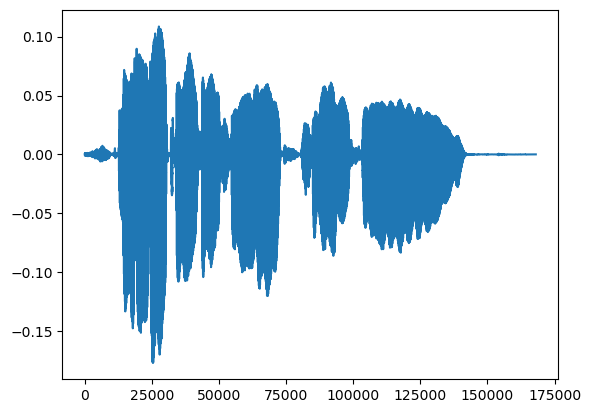

In [4]:
plt.plot(y[0].cpu().numpy())
plt.show()

Audio(y[0].cpu().numpy(), rate=sr)

In [15]:
with open(config_path) as f:
    config = yaml.safe_load(f)

model_configs = config["model"]

model_configs["feature_trsfm"]["init_args"]["sample_rate"] = model_configs["sample_rate"]
model_configs["feature_trsfm"]["init_args"]["window"] = model_configs["window"]
model_configs["feature_trsfm"]["init_args"]["hop_length"] = model_configs["hop_length"]
model_configs = dict2object(model_configs)

model = DDSPVocoder.load_from_checkpoint(ckpt_path, **model_configs).to(device)
model.eval()

DDSPVocoder(
  (encoder): DDSPAdd(
    (backbone): Mel2Control(
      (out_linear): Linear(in_features=192, out_features=233, bias=True)
      (stack): Sequential(
        (0): Conv1d(80, 96, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): GroupNorm(4, 96, eps=1e-05, affine=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Conv1d(96, 96, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (decoder): LSTM(96, 96, num_layers=3, batch_first=True, dropout=0.1, bidirectional=True)
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
  )
  (decoder): HarmonicPlusNoiseSynth(
    (harm_oscillator): HarmonicOscillator()
    (noise_generator): StandardNormalNoise()
    (noise_filter): LTVZeroPhaseFIRFilter()
  )
  (criterion): MSSLoss(
    (losses): ModuleList(
      (0-2): 3 x SSSLoss(
        (spec): Spectrogram()
      )
    )
  )
  (feature_trsfm): ScaledLogMelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
)

In [31]:
with torch.no_grad():
    feats = model.feature_trsfm(y)
    (
        f0_params,
        harm_osc_params,
        harm_filt_params,
        noise_filt_params,
        noise_params,
    ) = model.encoder(feats)
    f0_hat, *voicing_param = f0_params
    phase = f0_hat / sr
    ctx = TimeContext(120)
    upsampled_phase = linear_upsample(phase, ctx)
    if len(voicing_param) > 0:
        voicing_logits = voicing_param[0]
        voicing = voicing_logits.sigmoid()
        upsampled_voicing = linear_upsample(voicing, ctx)
        upsampled_phase = upsampled_phase * upsampled_voicing

print(y.shape)

phase_offsets = torch.nn.Parameter(
    torch.rand(1, y.shape[1] // phase_offset_hop_length + 1, device=device)
)

optimizer = torch.optim.Adam([phase_offsets], lr=lr)

decoder = model.decoder

def forward(offsets):
    upsampled_offsets = linear_upsample(smooth_phase_offset(offsets), TimeContext(phase_offset_hop_length))
    upsampled_offsets = upsampled_offsets[:, : upsampled_phase.shape[1]]
    harm_osc = decoder.harm_oscillator(upsampled_phase[:, : upsampled_offsets.shape[1]], *harm_osc_params, ctx=ctx, upsampled_phase_offset=upsampled_offsets)
    noise = decoder.noise_generator(harm_osc, *noise_params, ctx=ctx)
    if decoder.harm_filter is not None:
        harm_osc = decoder.harm_filter(harm_osc, *harm_filt_params, ctx=ctx)
    if decoder.noise_filter is not None:
        noise = decoder.noise_filter(noise, *noise_filt_params, ctx=ctx)

    out = harm_osc[:, : noise.shape[1]] + noise[:, : harm_osc.shape[1]]

    if decoder.end_filter is not None:
        return decoder.end_filter(out)
    else:
        return out


torch.Size([1, 168000])


In [53]:
with torch.no_grad():
    y_zero = forward(phase_offsets)

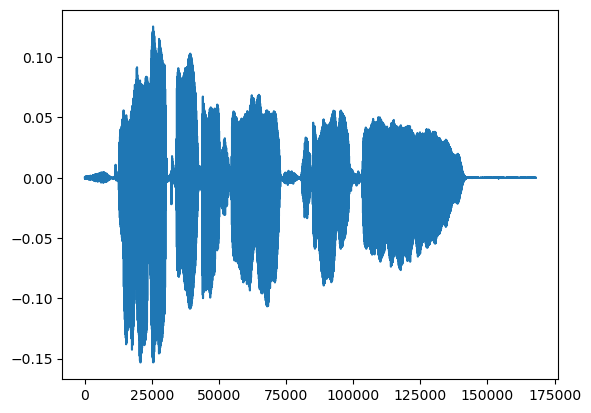

In [8]:
plt.plot(y_zero[0].cpu().numpy())
plt.show()

Audio(y_zero[0].cpu().numpy(), rate=sr)

In [32]:
pbar = tqdm(range(iterations))

for i in pbar:
    optimizer.zero_grad()
    y_hat = forward(phase_offsets)
    loss = torch.nn.functional.mse_loss(y[:, : y_hat.shape[1]], y_hat[:, : y.shape[1]])
    loss.backward()
    optimizer.step()
    pbar.set_description(f"Loss: {loss.item() * min(y.shape[1], y_hat.shape[1])}")

Loss: 80.13227814808488: 100%|██████████| 1000/1000 [01:05<00:00, 15.36it/s]


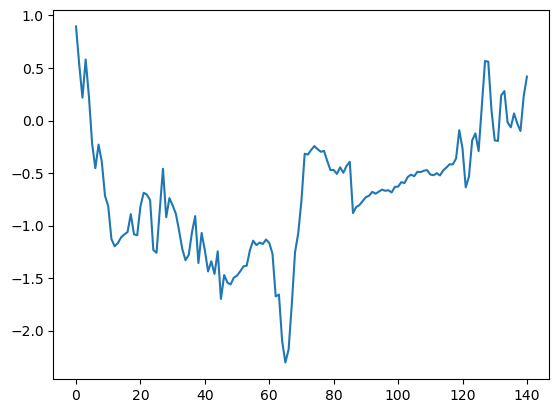

In [34]:
plt.plot(smooth_phase_offset(phase_offsets).detach().cpu().numpy()[0])
plt.show()

# torchaudio.save("ddsp_m1_3_phase_align.wav", y_hat.detach().cpu(), sr)

Audio(y_hat[0].detach().cpu().numpy(), rate=sr)

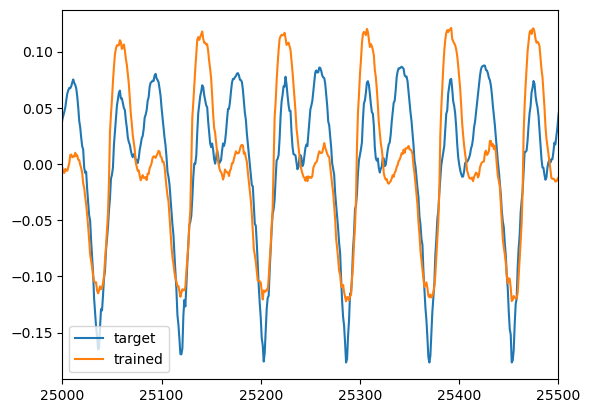

In [33]:
plt.plot(y.cpu().numpy()[0], label="target")
plt.plot(y_hat.detach().cpu().numpy()[0], label="trained")
# plt.plot(y_zero.detach().cpu().numpy()[0], label="zero", alpha=0.5)
plt.xlim(25000, 25500)
plt.legend()
plt.show()

In [44]:
ddsp_phase, sr = torchaudio.load("ddsp_m1_3_phase_align.wav")
sawsing_phase, _ = torchaudio.load("sawsing_m1_3_phase_align.wav")
pulse_phase, _ = torchaudio.load("pulse_m1_3_phase_align.wav")
glottal_phase, _ = torchaudio.load("glottal_m1_3_phase_align.wav")

y_np = y.squeeze().cpu().numpy()
ddsp_phase = ddsp_phase.squeeze().numpy()
sawsing_phase = sawsing_phase.squeeze().numpy()
pulse_phase = pulse_phase.squeeze().numpy()
glottal_phase = glottal_phase.squeeze().numpy()

ddsp_diff = y_np - ddsp_phase
sawsing_diff = y_np - sawsing_phase
pulse_diff = y_np - pulse_phase
glottal_diff = y_np - glottal_phase

Y = np.abs(librosa.stft(y_np, n_fft=1024, hop_length=256))
ref = np.max(Y)
Y = librosa.amplitude_to_db(Y, ref=ref)
ddsp_S = librosa.amplitude_to_db(np.abs(librosa.stft(ddsp_diff, n_fft=1024, hop_length=256)), ref=ref)
sawsing_S = librosa.amplitude_to_db(np.abs(librosa.stft(sawsing_diff, n_fft=1024, hop_length=256)), ref=ref)
pulse_S = librosa.amplitude_to_db(np.abs(librosa.stft(pulse_diff, n_fft=1024, hop_length=256)), ref=ref)
glottal_S = librosa.amplitude_to_db(np.abs(librosa.stft(glottal_diff, n_fft=1024, hop_length=256)), ref=ref)

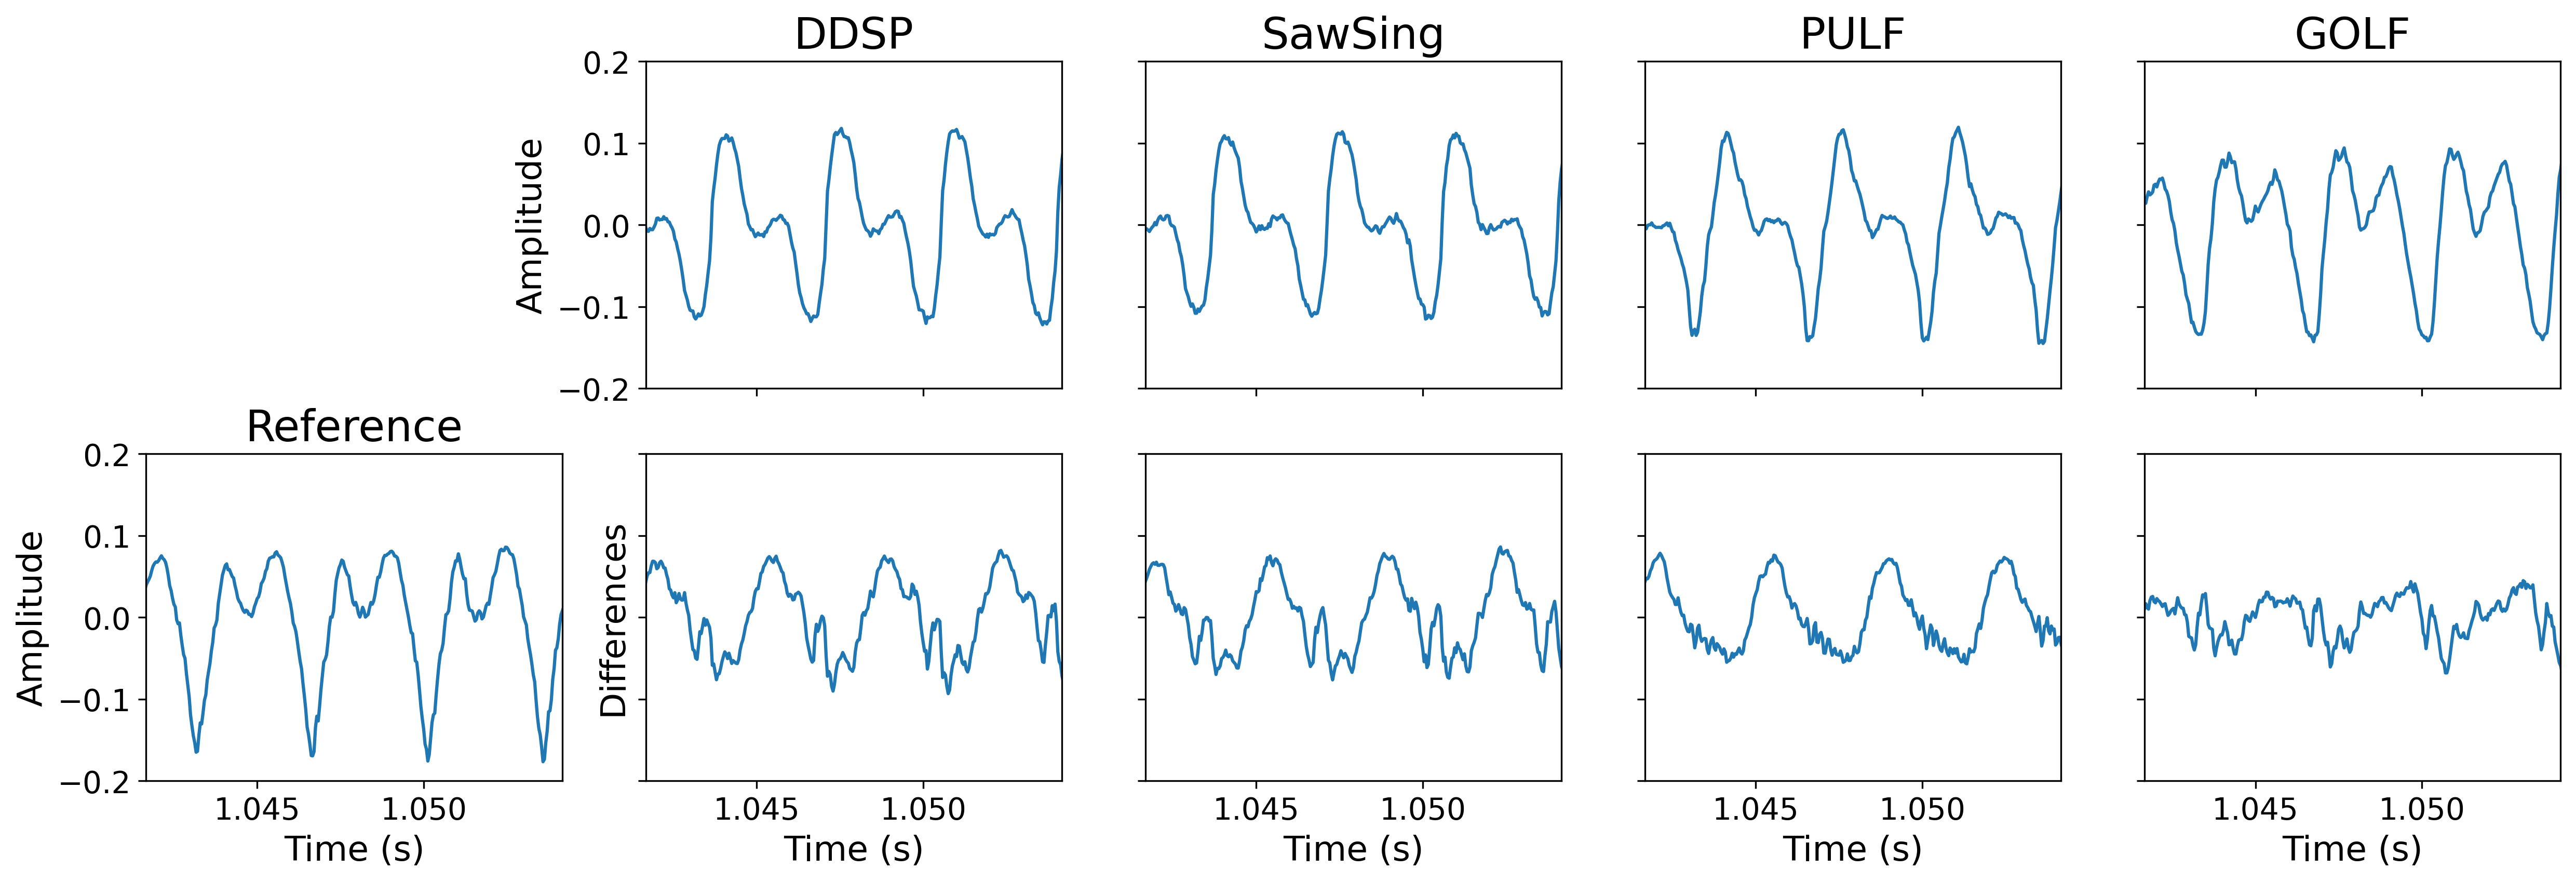

In [46]:
t = np.arange(y.shape[1]) / sr

fig, ax = plt.subplots(2, 5, sharey=True, sharex=True, figsize=(20, 6), dpi=300)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
ax[1, 0].plot(t, y_np, label="target")
ax[1, 0].set_xlim(25000 / sr, 25300 / sr)
ax[1, 0].set_ylim(-0.2, 0.2)
ax[1, 0].set_ylabel("Amplitude")
ax[1, 0].set_xlabel("Time (s)")
ax[1, 0].set_title("Reference")

ax[0, 1].plot(t, ddsp_phase, label="ddsp")
ax[0, 1].set_xlim(25000 / sr, 25300 / sr)
ax[0, 1].set_title("DDSP")
ax[0, 1].set_ylabel("Amplitude")
ax[0, 1].yaxis.set_tick_params(labelbottom=True)
ax[1, 1].set_xlabel("Time (s)")
ax[1, 1].set_ylabel("Differences")
ax[1, 1].plot(t, y_np - ddsp_phase)
# ax[1, 1].set_xlim(25000 / sr, 25300 / sr)

ax[0, 2].plot(t, sawsing_phase, label="sawsing")
ax[0, 2].set_xlim(25000 / sr, 25300 / sr)
ax[0, 2].set_title("SawSing")
ax[1, 2].set_xlabel("Time (s)")
ax[1, 2].plot(t, y_np - sawsing_phase)

ax[0, 3].plot(t, pulse_phase, label="pulse")
ax[0, 3].set_xlim(25000 / sr, 25300 / sr)
ax[0, 3].set_title("PULF")
ax[1, 3].plot(t, y_np - pulse_phase)
ax[1, 3].set_xlabel("Time (s)")

ax[0, 4].plot(t, glottal_phase, label="glottal")
ax[0, 4].set_xlim(25000 / sr, 25300 / sr)
ax[0, 4].set_title("GOLF")
ax[1, 4].plot(t, y_np - glottal_phase)
ax[1, 4].set_xlabel("Time (s)")
# plt.legend()

fig.delaxes(ax[0, 0])

plt.show()

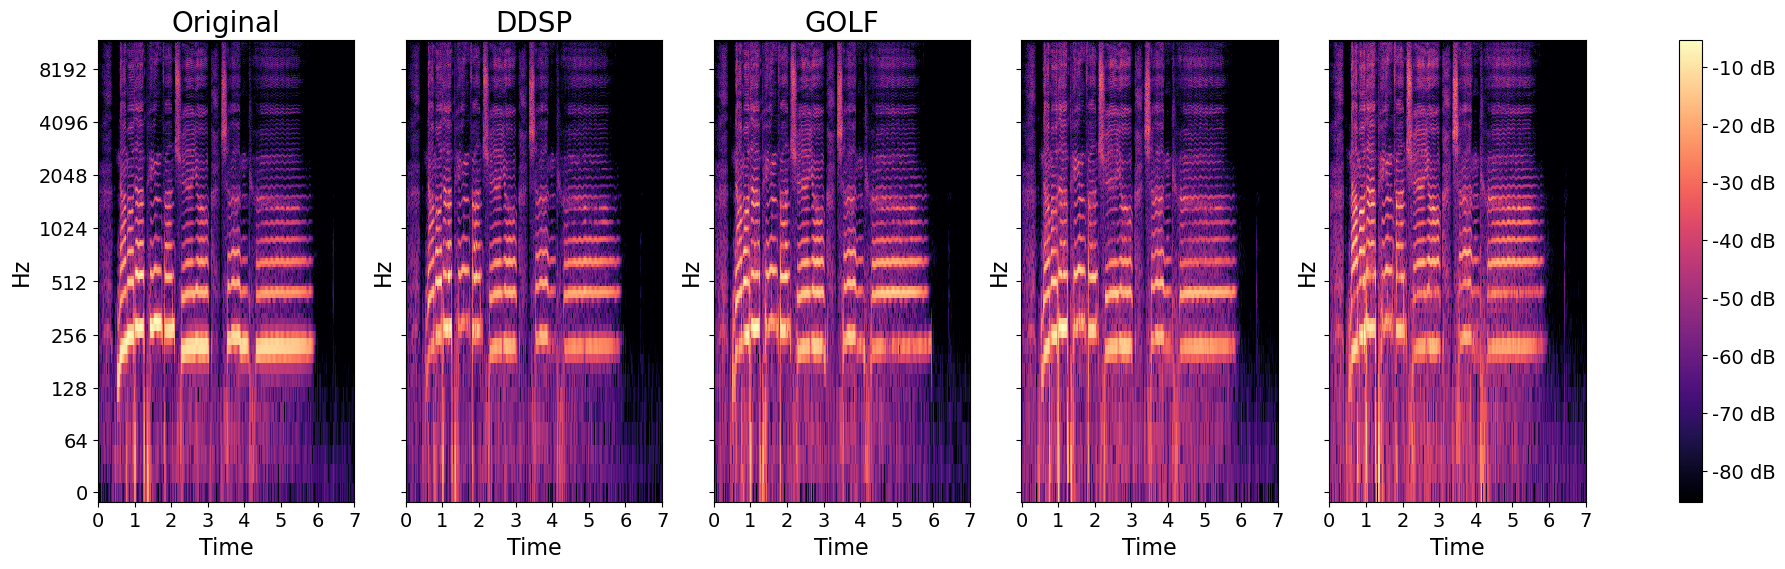

In [49]:
fig, ax = plt.subplots(1, 5, sharey=True, figsize=(24, 6))
img = specshow(Y, y_axis='linear', x_axis='time', n_fft=1024, hop_length=256, sr=sr, ax=ax[0])
ax[0].set(title='Original')
img = specshow(ddsp_S, y_axis='log', x_axis='time', n_fft=1024, hop_length=256, sr=sr, ax=ax[1])
ax[1].set(title='DDSP')
img = specshow(sawsing_S, y_axis='log', x_axis='time', n_fft=1024, hop_length=256, sr=sr, ax=ax[2])
ax[2].set(title='SawSing')
img = specshow(pulse_S, y_axis='log', x_axis='time', n_fft=1024, hop_length=256, sr=sr, ax=ax[3])
ax[2].set(title='PULF')
img = specshow(glottal_S, y_axis='log', x_axis='time', n_fft=1024, hop_length=256, sr=sr, ax=ax[4])
ax[2].set(title='GOLF')
plt.colorbar(img, ax=ax, format="%+2.0f dB")
# plt.savefig('s5_008_mic1.png')
plt.show()

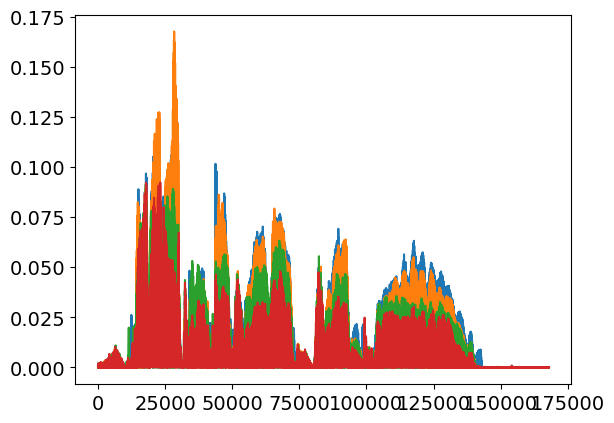

In [18]:
plt.plot(np.abs(y_np - sawsing_phase), label="sawsing")
plt.plot(np.abs(y_np - ddsp_phase), label="ddsp")

plt.plot(np.abs(y_np - pulse_phase), label="pulse")
plt.plot(np.abs(y_np - glottal_phase), label="glottal")

plt.show()

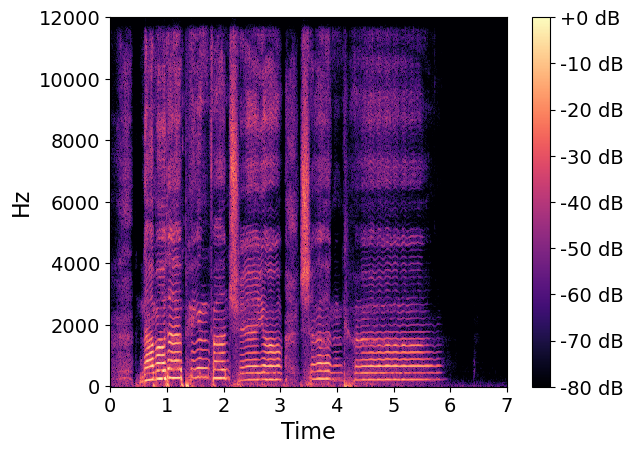

In [38]:
specshow(librosa.power_to_db(np.abs(librosa.stft(y_np - glottal_phase, n_fft=1024, hop_length=120)) ** 2, ref=np.max), sr=sr, hop_length=120, x_axis="time", y_axis="linear")
plt.colorbar(format="%+2.0f dB")
plt.show()

In [43]:
Audio(y_np - glottal_phase, rate=sr)

In [57]:
rd_03 = get_transformed_lf(0.3).numpy()
rd_04 = get_transformed_lf(0.4).numpy()
rd_08 = get_transformed_lf(0.8).numpy()
rd_12 = get_transformed_lf(1.2).numpy()
rd_27 = get_transformed_lf(2.7).numpy()

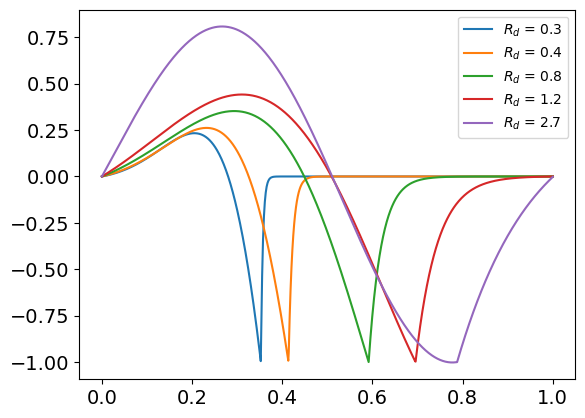

In [58]:
t = np.linspace(0, 1, rd_03.shape[0])
plt.plot(t, rd_03, label="$R_d$ = 0.3")
plt.plot(t, rd_04, label="$R_d$ = 0.4")
plt.plot(t, rd_08, label="$R_d$ = 0.8")
plt.plot(t, rd_12, label="$R_d$ = 1.2")
plt.plot(t, rd_27, label="$R_d$ = 2.7")
plt.legend()
plt.show()